In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.config import paths, params


cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

In [3]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere


DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, '5000s_Loc2Alt_Ori2_Geo3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

(5000, 176, 384)
(5000, 7)


In [4]:
from tqdm.notebook import tqdm

print(lfp[0,:,:].shape)
print(params.ELECTRODE_POSITION[:,:2].shape)

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _, _ = build_lfp_grid(lfp[i,:,:], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(176, 384)
(384, 2)


  0%|          | 0/5000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [5]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [6]:
import json

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
print(inference_list)
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)

normalize_labels = True

if normalize_labels:
    for i in range(labels.shape[1]):
        label = labels[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
        x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
        labels[:,i] = x_scaled
    print(labels)

['d', 'theta', 'h', 'phi', 'r_s', 'l_t', 'r_t']
[[-0.54532796  0.37131608 -0.49500421 ...  0.73781562 -0.83946082
   0.95837609]
 [-0.36648332 -0.00526815 -0.23215701 ...  0.98998876  0.98819733
   0.09896418]
 [ 0.59473091 -0.46328736  0.28060196 ... -0.84130665 -0.64965705
  -0.29627192]
 ...
 [ 0.36562874 -0.04099938 -0.66262443 ... -0.43724986 -0.30330637
   0.00869299]
 [ 0.25605996  0.84270965 -0.80643747 ... -0.70096912 -0.10771506
  -0.64395145]
 [-0.86443862 -0.06593687  0.74004953 ...  0.06150768 -0.64712144
  -0.73398633]]


In [7]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(5000, 40)


In [8]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=7)

device = torch.device("cpu") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 35, learning_rate=0.001, decay_rate=0.99, device=device)

  3%|▎         | 1/35 [00:03<01:49,  3.22s/it]

Training Loss: 487.74025225639343 Validation Loss: 159.32383088767529


 31%|███▏      | 11/35 [00:33<01:12,  3.03s/it]

Training Loss: 261.67214880138636 Validation Loss: 88.17240611463785


 60%|██████    | 21/35 [01:03<00:42,  3.02s/it]

Training Loss: 239.62115170620382 Validation Loss: 85.9630888234824


 89%|████████▊ | 31/35 [01:33<00:12,  3.01s/it]

Training Loss: 223.30036951042712 Validation Loss: 83.15425933897495


100%|██████████| 35/35 [01:46<00:00,  3.04s/it]


In [9]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: 0.5079067676885216
(128, 7)
(128, 7)


In [16]:
if normalize_labels:
    for i in range(y.shape[1]):
        old_y = y[:,i]
        old_out = output[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_y = (((old_y - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        
        org_out = (((old_out - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        y[:,i] = org_y
        output[:,i] = org_out

<IPython.core.display.Javascript object>


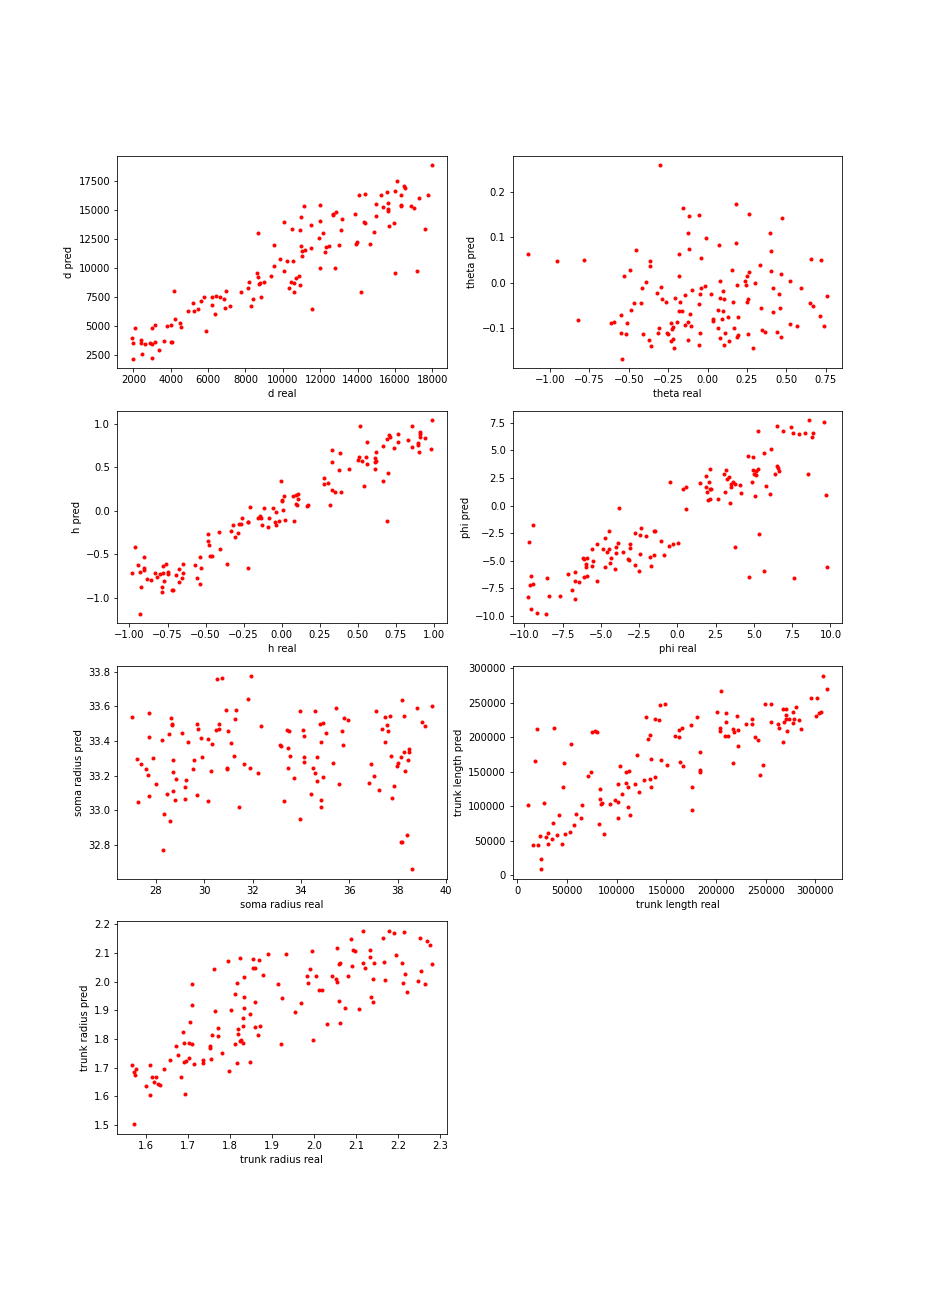

In [17]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(13, 18))

# ax_y = plt.subplot(421)
# ax_y.scatter(y[:,0], output[:,0], c='red', marker='.')
# ax_y.set_xlabel('y real')
# ax_y.set_ylabel('y pred')

ax_d = plt.subplot(421)
ax_d.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(422)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(423)
ax_h.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(424)
ax_p.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

ax_lt = plt.subplot(425)
ax_lt.scatter(y[:,4], output[:,4], c='red', marker='.')
ax_lt.set_xlabel('soma radius real')
ax_lt.set_ylabel('soma radius pred')

ax_lt = plt.subplot(426)
ax_lt.scatter(y[:,5], output[:,5], c='red', marker='.')
ax_lt.set_xlabel('trunk length real')
ax_lt.set_ylabel('trunk length pred')

ax_lt = plt.subplot(427)
ax_lt.scatter(y[:,6], output[:,6], c='red', marker='.')
ax_lt.set_xlabel('trunk radius real')
ax_lt.set_ylabel('trunk radius pred')


plt.show()

In [21]:
from cell_inference.utils.feature_extractors.SummaryStats2D import get_y_window

DATA_PATH = 'cell_inference/resources/invivo'

INVIVO_PATH = os.path.join(DATA_PATH, 'all_cell_LFP_2D.h5')

with h5py.File(INVIVO_PATH, "r") as f:
    c = f['coord'][:]
    d = f['data'][:]

test_data = []
summ_stats = []
y_pos = []

print(lfp.shape)

for i in tqdm(range(d.shape[2])):
    g_lfp, g_coords, y_i = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION, y_window_size=960.0)
    summ_stats.append(calculate_stats(g_lfp))
    test_data.append(g_lfp)
    y_pos.append(y_i)

test_data = np.stack(test_data, axis=0)
summ_stats = np.stack(summ_stats, axis=0)
y_pos = np.stack(y_pos, axis=0)
print(y_pos)

(5000, 176, 384)


  0%|          | 0/383 [00:00<?, ?it/s]

[ -50.   10.   10.   70.   30.   10.  -50.   10.  -30.  130.   10.   10.
  -50.  -10.  -10.  -10.  -50.  -30.  -10.  -10.   10.  -10.   10.  130.
   10.   50.  -10.   10.   50.  -30.   10.   30.   70.  -30.   30.  -10.
   10.  -30. -130.   10.   30.   30.  -10.  -10.   70.   10.  -10.  -70.
   10.  -30.   90.  -10.  -10.   10.   10.  -30.  -70.  -10.   10.   30.
   10.   10.  -10.   10.  -10.  -10.   10.   30.   10.   10.   30.  -10.
  -10.  -30.   30.   10.  -10.   10.   50.   10.   10.  -10.   10.  -70.
   10.  210.   70.  250.  -90.  -10.   10.  -10.   50.   30.   10.   10.
  -10.   50.  -10.   10.  -10.   30. -310.   10.   30.  110.  -10.  -70.
  -10.  -10.   10.   70.   30.   30.  -10. -210.  -10.  -30.   90.  -10.
   70.   10.   70.   10.  -10.  -90.  -10.   10.   10.  110.  -30.   10.
   10.   30.   10.   30.   70.   30.   30.   50.   10.  -10.   50.  -50.
 -110.   10.  -50.  -50.  -10.  -30.  -10.  -30.  -70.  -50.  -70.  -10.
   10.  -10.   10.   10.  -50.  -50.  -30.   30.   

In [26]:
y_pos = y_pos.reshape((-1, 1))
print(y_pos.shape)

np.set_printoptions(suppress=True)

model1.eval()
summ_stats = torch.Tensor(summ_stats)
summ_stats_tensor = summ_stats.to(device)
pred = model1(summ_stats_tensor)
pred = np.squeeze(pred.to("cpu").detach().numpy())

print(pred.shape)

if normalize_labels:
    for i in range(pred.shape[1]):
        old_pred = pred[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_pred = (((old_pred - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        pred[:,i] = org_pred
        
y_pred = np.concatenate((y_pos, pred), axis=-1)
df = pd.DataFrame(y_pred, columns=['y'] + inference_list).sort_values(by='y')
display(df)

(383, 1)
(383, 7)


,y,d,theta,h,phi,r_s,l_t,r_t
347,-350.0,193.096390,0.020433,-1.039482,1.450461,9.470501,303.111328,0.729718
102,-310.0,149.048355,-0.012911,-0.979378,-0.332943,9.440589,600.419006,0.843034
308,-310.0,173.423767,0.041337,-0.651006,-3.095127,9.406183,226.838226,1.022934
242,-290.0,173.392426,0.081659,-0.979504,-2.074691,9.242894,646.957947,0.782664
226,-270.0,165.257996,-0.015770,-0.944397,2.174812,9.421798,569.210510,0.729029
...,...,...,...,...,...,...,...,...
183,210.0,169.815796,0.081301,0.795031,1.358123,9.676537,172.667221,0.855091
240,210.0,182.509674,0.067075,0.792500,0.959430,9.506356,614.152649,0.899200
85,210.0,160.049927,0.037309,0.937872,1.441956,9.449089,650.477356,1.322928
299,230.0,185.339951,-0.048303,0.771908,-1.926007,9.494780,539.899231,1.291552


In [27]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,y,d,theta,h,phi,r_s,l_t,r_t
347,-350.0,193.096390,0.020433,-1.039482,1.450461,9.470501,303.111328,0.729718
102,-310.0,149.048355,-0.012911,-0.979378,-0.332943,9.440589,600.419006,0.843034
308,-310.0,173.423767,0.041337,-0.651006,-3.095127,9.406183,226.838226,1.022934
242,-290.0,173.392426,0.081659,-0.979504,-2.074691,9.242894,646.957947,0.782664
226,-270.0,165.257996,-0.015770,-0.944397,2.174812,9.421798,569.210510,0.729029
328,-230.0,190.559052,0.009831,-0.898409,0.429078,9.444918,349.594818,0.822200
115,-210.0,171.562500,-0.021940,-0.703224,-2.241593,9.407848,402.978516,0.959728
332,-210.0,176.365784,-0.068638,-0.700295,-2.306655,9.451631,384.678772,1.225190
258,-170.0,161.224731,-0.052542,-0.649070,-2.312636,9.393921,595.352234,1.100293
38,-130.0,87.574608,0.042335,-0.838110,-2.586235,9.613482,248.721451,1.481021


(49, 176)
(49,)
(176,)


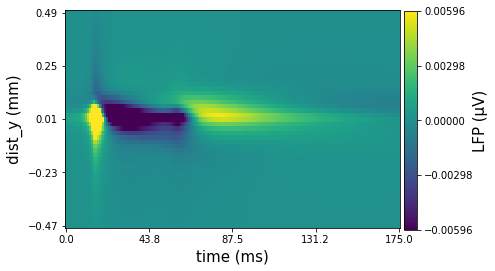

In [15]:
%matplotlib inline

cell_idx = 0

t = np.arange(test_data.shape[1])

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(g_coords[:,0])
e_idx = ((g_coords[:,0]==x_dist[ix]) & 
         (g_coords[:,1]>=ylim[0]) & 
         (g_coords[:,1]<=ylim[1]))

print(test_data[0,:,e_idx].shape)
print(g_coords[e_idx, 1].shape)
print(t.shape)

_ = plot_lfp_heatmap(t,
                     g_coords[e_idx, 1],
                     np.transpose(test_data[0,:,e_idx]), vlim='auto',
                     fontsize=15,labelpad=0,ticksize=10,nbins=5)